# Long Short Term Memory (LSTM)

Using TensorFlow backend.
C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
W0811 23:57:09.830587 14044 deprecation_wrapper.py:119] From C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 23:57:09.847633 14044 deprecation_wrapper.py:119] From C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 23:57:09.849638 14044 deprecation_wrapper.py:119] From C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is d

Epoch 1/1
 - 39s - loss: 0.0101


C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\212607214\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


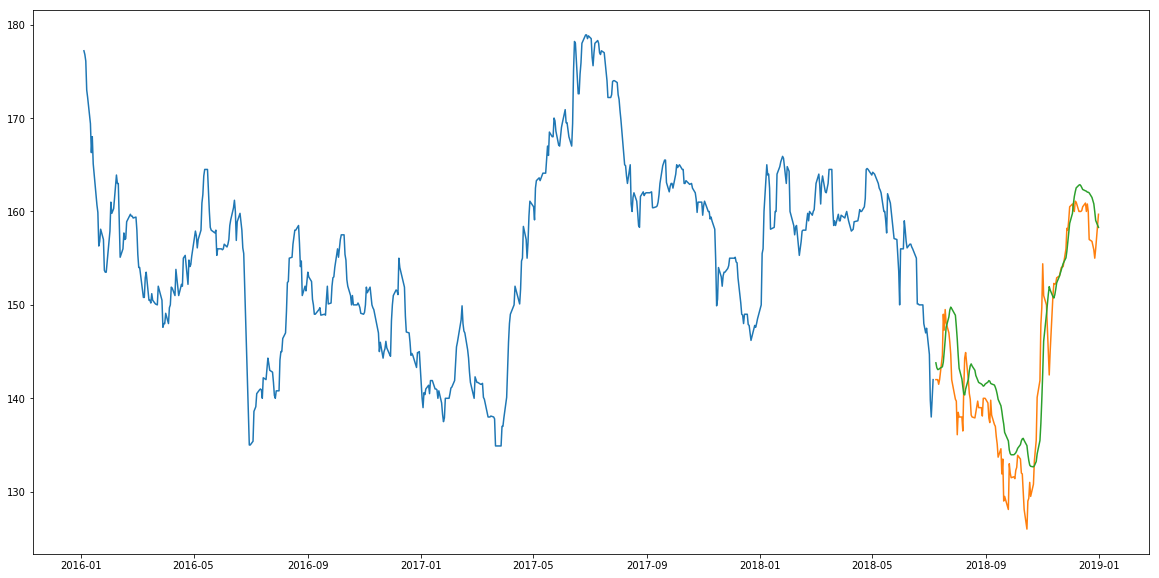

In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_excel('JKH.xlsx', 'Sheet1')

#print the head
df.head()

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'CLOSE_PRICE'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['CLOSE_PRICE'][i] = data['CLOSE_PRICE'][i]
    
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:600,:]
valid = dataset[600:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

#for plotting
train = new_data[:600]
valid = new_data[600:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10))
plt.plot(train['CLOSE_PRICE'])
plt.plot(valid[['CLOSE_PRICE','Predictions']])

In [2]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint

date_sentiments = {}
# html = urlopen("http://www.sundaytimes.lk/business")
#     bsObj = BeautifulSoup(html, features="html.parser")
#     posts = bsObj.findAll("div", {"class": "col-md-7"})
#     # print(posts)
#     for post in posts:
#         time.sleep(1)
#         url = post.a['href']
#         date = post.p.span.text
#         print(date,url)

for i in range(5,10):
    html = urlopen("http://www.sundaytimes.lk/search/John%20keells/"+str(i))
    bsObj = BeautifulSoup(html, features="html.parser")
    posts = bsObj.findAll("div", {"class": "col-md-7"})
    # print(posts)
    for post in posts:
        time.sleep(1)
        url = post.a['href']
        date = post.p.span.text
        date = date[1:-3]
        date = date.replace(',', '')
        date = datetime.strptime(date, "%B %d %Y %H:%M").strftime("%d/%m/%Y");
#         print(newDate)
#         print(date,url)
        try:
            link_page = urlopen(url).read()
        except:
            url = url[:-2]
            link_page = urlopen(url).read()
        link_soup = BeautifulSoup(link_page,"html5lib")
        sentences = link_soup.findAll("p")
        
#         print(sentences)
        
        passage = ""
        for sentence in sentences:
            if('class' in sentence.attrs):
                unwanted = sentence.text
            else:
                passage += sentence.text 
        sentiment = sia.polarity_scores(passage)['compound']
        date_sentiments.setdefault(date, []).append(sentiment)
#         print(date_sentiments)

date_sentiment = {}

for k,v in date_sentiments.items():
    date_sentiment[datetime.strptime(k, '%d/%m/%Y').date() + timedelta(days=1)] = round(sum(v)/float(len(v)),3)

earliest_date = min(date_sentiment.keys())
print(earliest_date)
# print(date_sentiment)


2018-09-26


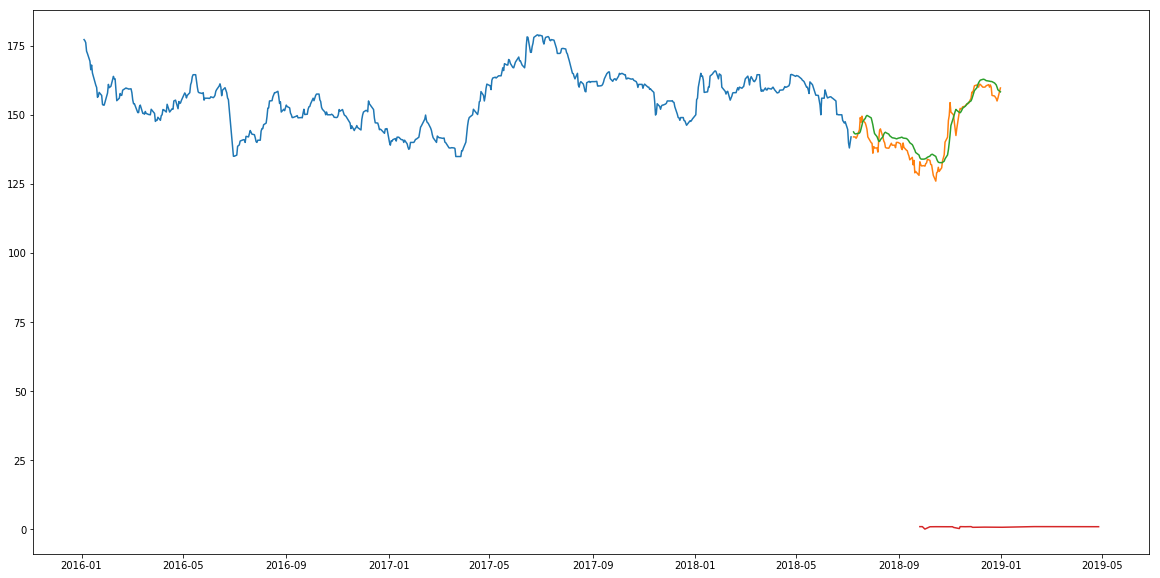

In [3]:
#for plotting
train = new_data[:600]
valid = new_data[600:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10))
plt.plot(train['CLOSE_PRICE'])
plt.plot(valid[['CLOSE_PRICE','Predictions']])
plt.plot(date_sentiment.keys(),date_sentiment.values())